In [1]:
from itertools import combinations, product
from functools import partial
import numpy as np
from numpy.linalg import norm
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# import yfinance as yf

# def load_close_prices(tickers):
# #     prices are not adjusted for splits or dividends
#     history = {
#         tic: yf.Ticker(tic).history(period='max')
#         for tic in tickers}
#     indexes = [set(data.index) for data in history.values()]
#     index = sorted(set.union(*indexes))
#     closes = pd.concat([
#         history[tic].reindex(index=index)['Close'].ffill()
#         for tic in tickers], axis=1)
#     closes.columns = tickers
#     stacked = closes.stack().reset_index()
#     stacked.columns = ['date', 'ticker', 'price']
#     return stacked

# yf_tickers = [
#     'nio', 'dwac', 'edu', 'didi', 'gme', 'aapl', 'tsla', 'amc', 'pg', 'f', 'snap', 'amzn',
#     'dis', 'msft', 'ge', 'rivn', 'bros', 'goog', 'googl', 'ccl', 'amd', 'nvda']
# prices = (
#     load_close_prices(yf_tickers)
#     .pivot(index='date', columns='ticker', values='price')
# )
# prices.to_parquet('prices_yf.parquet')

# Normalized prices and " returns "

In [3]:
prices = pd.read_parquet('prices_yf.parquet')
THRES = 0.8
N_DAYS = 500
nulls = prices.isnull().mean(axis=0)
stocks_w_nans = nulls[nulls > THRES].sort_values()
stocks_w_nans

ticker
tsla    0.801773
amc     0.859245
snap    0.912118
nio     0.937471
didi    0.983711
bros    0.987192
dwac    0.987915
rivn    0.989819
dtype: float64

In [4]:
cols = prices.columns
stocks = cols[~cols.isin(stocks_w_nans.index)]
prices = (
    prices
    .loc[:, stocks]
    .ffill()
    .dropna()
    .iloc[:N_DAYS, :]
)
returns = prices.pct_change().iloc[1:, :]  # not clean
returns

ticker,aapl,amd,amzn,ccl,dis,edu,f,ge,gme,goog,googl,msft,nvda,pg
date,,,,,,,,,,,,,,
2006-09-18,-0.002834,0.029778,-0.013530,-0.023967,-0.008248,0.053030,-0.024938,0.000574,0.010493,0.011735,0.011735,-0.002235,0.037889,-0.006568
2006-09-19,-0.001624,-0.014275,-0.015586,0.001403,0.013639,-0.044964,-0.020460,-0.000574,-0.003738,-0.026237,-0.026236,0.002613,-0.026076,0.006778
2006-09-20,0.020198,0.016710,0.017099,0.017749,0.018379,0.026365,0.011749,0.004878,0.008338,-0.016864,-0.016864,0.011914,0.036480,0.011820
2006-09-21,-0.008105,-0.014609,-0.059153,0.026847,-0.010313,-0.016147,0.001290,-0.009491,0.009923,0.024811,0.024811,-0.010302,-0.008073,0.001785
2006-09-22,-0.022103,-0.028540,0.020516,-0.001117,-0.020515,-0.045133,0.030928,-0.001162,-0.035209,-0.007546,-0.007546,-0.008922,-0.029622,0.001134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-09-04,-0.034379,-0.050406,-0.033923,-0.029450,-0.029837,-0.024704,-0.039387,-0.030451,0.000683,-0.030469,-0.030469,-0.020446,-0.013722,-0.013722
2008-09-05,-0.006451,0.020548,0.014866,0.028760,-0.005707,-0.022145,0.004556,0.006498,-0.006829,-0.013348,-0.013348,-0.026565,0.014783,0.004827
2008-09-08,-0.014109,0.018456,0.024877,0.044114,0.049745,0.019686,0.031746,0.043400,0.014898,-0.054699,-0.054699,0.018323,-0.041132,0.022464


# Plots

<AxesSubplot:xlabel='f', ylabel='pg'>

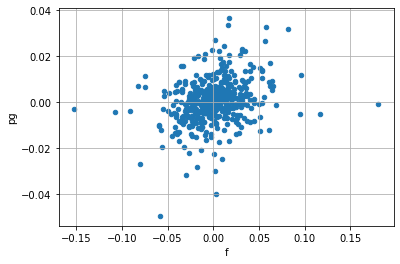

In [5]:
cpl = ('f', 'pg')
dic_cpl = {'x': cpl[0], 'y': cpl[1]}
returns_cpl = returns.loc[:, cpl]
returns.plot.scatter(**dic_cpl, grid=True)

<AxesSubplot:xlabel='f', ylabel='pg'>

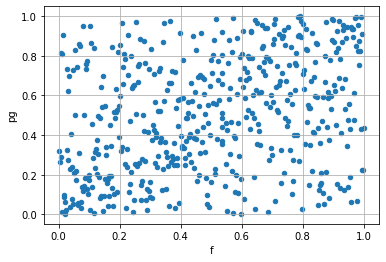

In [6]:
ranks = returns_cpl.rank()
ranks = ranks / ranks.max()
ranks.plot.scatter(**dic_cpl, grid=True)

In [7]:
ranks_vals = ranks.values
xxx = ranks_vals[:, 0]
yyy = ranks_vals[:, 1]

In [8]:
def log_clayton(theta):
    return (1 / theta * np.log(xxx ** -theta + yyy ** -theta - 1)).sum()

def jac(theta):
    return (
        - 1 / theta ** 2 * np.log(xxx ** -theta + yyy ** -theta - 1)
        - (xxx ** -(theta + 1) + yyy ** -(theta + 1)) / (xxx ** -theta + yyy ** -theta - 1)
    ).sum()

<ipython-input-8-3038d82f030e>:2: RuntimeWarning: overflow encountered in power
  return (1 / theta * np.log(xxx ** -theta + yyy ** -theta - 1)).sum()


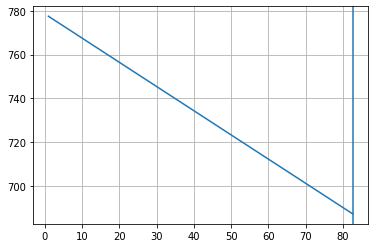

In [9]:
thetas = np.linspace(1, 4e3)
vals = [log_clayton(theta) for theta in thetas]
argmin = thetas[np.argmin(vals)]
plt.plot(thetas, vals)
plt.axvline(argmin)
plt.grid(True)

In [10]:
minimize(log_clayton, 1, method='L-BFGS-B')

<ipython-input-8-3038d82f030e>:2: RuntimeWarning: overflow encountered in power
  return (1 / theta * np.log(xxx ** -theta + yyy ** -theta - 1)).sum()
/home/tibo/.local/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 687.1403074013218
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00114824])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 42
      nit: 19
     njev: 21
   status: 0
  success: True
        x: array([101.72972723])

In [11]:
minimize(log_clayton, 1, method='L-BFGS-B', jac=jac)

<ipython-input-8-3038d82f030e>:2: RuntimeWarning: overflow encountered in power
  return (1 / theta * np.log(xxx ** -theta + yyy ** -theta - 1)).sum()
<ipython-input-8-3038d82f030e>:6: RuntimeWarning: overflow encountered in power
  - 1 / theta ** 2 * np.log(xxx ** -theta + yyy ** -theta - 1)
<ipython-input-8-3038d82f030e>:7: RuntimeWarning: overflow encountered in power
  - (xxx ** -(theta + 1) + yyy ** -(theta + 1)) / (xxx ** -theta + yyy ** -theta - 1)
<ipython-input-8-3038d82f030e>:7: RuntimeWarning: invalid value encountered in true_divide
  - (xxx ** -(theta + 1) + yyy ** -(theta + 1)) / (xxx ** -theta + yyy ** -theta - 1)


      fun: 697.5263215837732
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5587.95862548])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 25
      nit: 2
     njev: 25
   status: 0
  success: True
        x: array([6.])

In [25]:
def wrapper_minimize(method, with_jac):
    kwarg = {'jac': jac} if with_jac else {}
    res = dict(minimize(log_clayton, 1, method=method, **kwarg))
#     res['x'] = res['x'][0] if len(res['x']) > 0 else res['x']
    res = {k: v for k, v in res.items() if k in ['nit', 'nfev', 'status', 'success', 'message', 'x']}
    return pd.Series(res).rename(method + ('_with_jac' if with_jac else '_without_jac'))

In [26]:
methods_w_jac = [
#     'Newton-CG',
#     'dogleg',
#     'trust-ncg',
#     'trust-exact',
#     'trust-krylov',
]
methods_wo_jac = [
    'Nelder-Mead',
    'Powell',
    'CG',
    'BFGS',
    'L-BFGS-B',
    'TNC',
    'COBYLA',
    'SLSQP',
    'trust-constr',
]

params = pd.DataFrame(
    data=list(product(methods_wo_jac, [True, False]))
    + list(product(methods_w_jac, [True])))
params.columns = ['method', 'with_jac']
params.dtypes

method      object
with_jac      bool
dtype: object

In [27]:
res = {
    param: wrapper_minimize(param.method, param.with_jac)
    for param in params.itertuples()}
res = pd.concat(res.values(), axis=1)

/home/tibo/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:519: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,
<ipython-input-8-3038d82f030e>:2: RuntimeWarning: overflow encountered in power
  return (1 / theta * np.log(xxx ** -theta + yyy ** -theta - 1)).sum()
/home/tibo/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:519: RuntimeWarning: Method Powell does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,
<ipython-input-8-3038d82f030e>:6: RuntimeWarning: overflow encountered in power
  - 1 / theta ** 2 * np.log(xxx ** -theta + yyy ** -theta - 1)
<ipython-input-8-3038d82f030e>:7: RuntimeWarning: overflow encountered in power
  - (xxx ** -(theta + 1) + yyy ** -(theta + 1)) / (xxx ** -theta + yyy ** -theta - 1)
<ipython-input-8-3038d82f030e>:7: RuntimeWarning: invalid value encountered in true_divide
  - 

/home/tibo/.local/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/qp_subproblem.py:573: RuntimeWarning: invalid value encountered in double_scalars
  alpha = rt_g / pt_H_p


In [28]:
res

,Nelder-Mead_with_jac,Nelder-Mead_without_jac,Powell_with_jac,Powell_without_jac,CG_with_jac,CG_without_jac,BFGS_with_jac,BFGS_without_jac,L-BFGS-B_with_jac,L-BFGS-B_without_jac,TNC_with_jac,TNC_without_jac,COBYLA_with_jac,COBYLA_without_jac,SLSQP_with_jac,SLSQP_without_jac,trust-constr_with_jac,trust-constr_without_jac
nit,41,41,2,2,0,31,2,19,2,19,2,1,NaN,NaN,100,27,1000,1000
nfev,82,82,44,44,26,930,143,63,25,42,54,142,138,138,1090,85,114,42
status,0,0,0,0,2,3,2,2,0,0,1,4,1,1,9,0,0,0
success,True,True,True,True,False,False,False,False,True,True,True,False,True,True,False,True,False,False
message,Optimization terminated successfully.,Optimization terminated successfully.,Optimization terminated successfully.,Optimization terminated successfully.,Desired error not necessarily achieved due to ...,NaN result encountered.,Desired error not necessarily achieved due to ...,Desired error not necessarily achieved due to ...,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,Converged (|f_n-f_(n-1)| ~= 0),Linear search failed,Optimization terminated successfully.,Optimization terminated successfully.,Iteration limit reached,Optimization terminated successfully,The maximum number of function evaluations is ...,The maximum number of function evaluations is ...
x,[114.24863281250013],[114.24863281250013],[114.24865816900369],[114.24865816900369],[1.0],[114.4460774589362],[35.7236796827998],[113.60084687960483],[6.0],[101.729727226921],[21.000000000000078],[20.999999999999954],114.248779296875,114.248779296875,[4.570931997589574],[114.2452698864288],[114.0],[101.82986583949983]


In [15]:
res.loc[:, res.loc['success', :]]

,0,1,2,3,8,9,10,12,13,15
nit,41,41,2,2,2,19,2,NaN,NaN,27
nfev,82,82,44,44,25,42,54,138,138,85
status,0,0,0,0,0,0,1,1,1,0
success,True,True,True,True,True,True,True,True,True,True
message,Optimization terminated successfully.,Optimization terminated successfully.,Optimization terminated successfully.,Optimization terminated successfully.,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,Converged (|f_n-f_(n-1)| ~= 0),Optimization terminated successfully.,Optimization terminated successfully.,Optimization terminated successfully
x,[114.24863281250013],[114.24863281250013],[114.24865816900369],[114.24865816900369],[6.0],[101.729727226921],[21.000000000000078],114.248779296875,114.248779296875,[114.2452698864288]
